# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

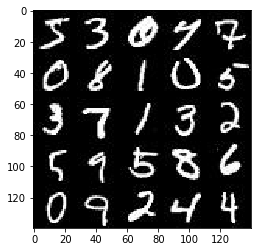

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

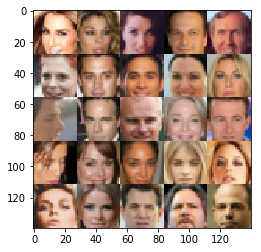

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder( tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs    = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, (None), name='learn_rate')

    return (real_inputs, z_inputs, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        output = tf.tanh(logits)
        
        return output
    
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    """
    # Smoothing 
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    """
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    samples, width, height, channels = data_shape
    
    real_inputs, z_inputs, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({real_inputs: batch_images, z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_inputs, channels, data_image_mode)




### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.7739... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 2.7982... Generator Loss: 0.5345
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 1.6157
Epoch 1/2... Discriminator Loss: 3.0813... Generator Loss: 0.1969
Epoch 1/2... Discriminator Loss: 2.1979... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 2.4555... Generator Loss: 1.7291
Epoch 1/2... Discriminator Loss: 1.9995... Generator Loss: 0.2443
Epoch 1/2... Discriminator Loss: 2.1899... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 2.2478... Generator Loss: 1.4224


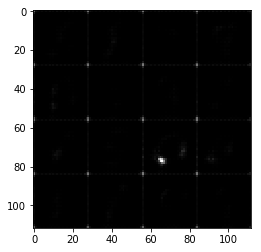

Epoch 1/2... Discriminator Loss: 1.6947... Generator Loss: 0.9743
Epoch 1/2... Discriminator Loss: 1.7943... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.7227... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 2.0298... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 2.0916... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.7366


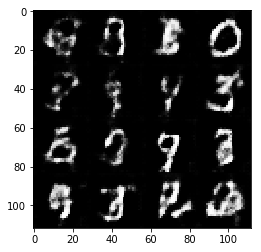

Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.7502... Generator Loss: 0.3167
Epoch 1/2... Discriminator Loss: 2.2368... Generator Loss: 0.1792
Epoch 1/2... Discriminator Loss: 2.1414... Generator Loss: 0.2668
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.5406... Generator Loss: 0.4199
Epoch 1/2... Discriminator Loss: 1.7158... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 2.2003... Generator Loss: 0.1690
Epoch 1/2... Discriminator Loss: 1.7558... Generator Loss: 0.3052


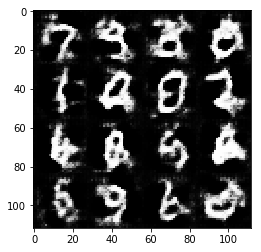

Epoch 1/2... Discriminator Loss: 2.0279... Generator Loss: 1.5045
Epoch 1/2... Discriminator Loss: 1.8563... Generator Loss: 1.3074
Epoch 1/2... Discriminator Loss: 1.7114... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 1.7286... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 1.8418... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 1.9636... Generator Loss: 0.2148
Epoch 1/2... Discriminator Loss: 1.8362... Generator Loss: 0.2666
Epoch 1/2... Discriminator Loss: 2.1481... Generator Loss: 0.1852


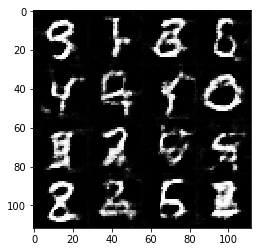

Epoch 1/2... Discriminator Loss: 1.9943... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 1.8656... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.7023... Generator Loss: 0.3972
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.8250... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 1.9107... Generator Loss: 0.2396
Epoch 1/2... Discriminator Loss: 2.2437... Generator Loss: 1.9010
Epoch 1/2... Discriminator Loss: 1.8881... Generator Loss: 1.5488
Epoch 1/2... Discriminator Loss: 1.6473... Generator Loss: 0.3271


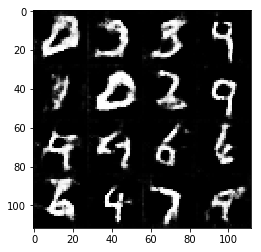

Epoch 1/2... Discriminator Loss: 1.7075... Generator Loss: 0.3416
Epoch 1/2... Discriminator Loss: 1.9566... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.7742... Generator Loss: 0.2959
Epoch 1/2... Discriminator Loss: 2.0039... Generator Loss: 0.2298
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.6072
Epoch 1/2... Discriminator Loss: 1.7763... Generator Loss: 1.1259
Epoch 1/2... Discriminator Loss: 2.0919... Generator Loss: 0.1937
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 2.1125... Generator Loss: 0.1600
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 1.2799


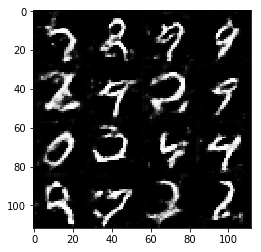

Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 2.1404... Generator Loss: 0.1597
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 1.6635... Generator Loss: 1.2080
Epoch 1/2... Discriminator Loss: 1.4380... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 1.2725
Epoch 1/2... Discriminator Loss: 1.7267... Generator Loss: 0.3784
Epoch 1/2... Discriminator Loss: 1.8769... Generator Loss: 1.5565
Epoch 1/2... Discriminator Loss: 1.7347... Generator Loss: 1.5276


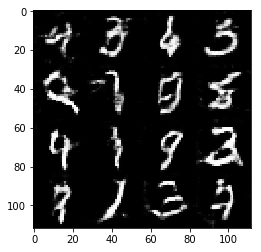

Epoch 1/2... Discriminator Loss: 2.1549... Generator Loss: 0.1763
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 1.9215... Generator Loss: 1.5782
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 1.3871
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.8963... Generator Loss: 0.2718
Epoch 1/2... Discriminator Loss: 1.9076... Generator Loss: 0.2401
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.6951


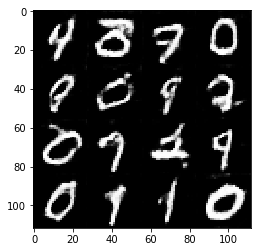

Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 2.3283... Generator Loss: 0.1358
Epoch 1/2... Discriminator Loss: 2.1397... Generator Loss: 2.2879
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 2.5340... Generator Loss: 0.1207
Epoch 1/2... Discriminator Loss: 1.9069... Generator Loss: 1.2348
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.6197... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.7153


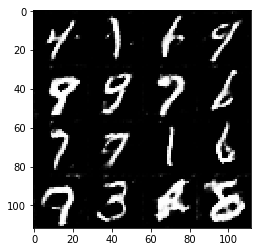

Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.5208
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 2.3273... Generator Loss: 0.1347
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.9335
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 2.1221... Generator Loss: 0.1671


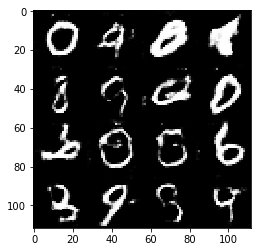

Epoch 2/2... Discriminator Loss: 2.1140... Generator Loss: 0.1757
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.4876... Generator Loss: 0.4048
Epoch 2/2... Discriminator Loss: 1.5211... Generator Loss: 0.4806
Epoch 2/2... Discriminator Loss: 1.9775... Generator Loss: 1.7434
Epoch 2/2... Discriminator Loss: 1.6204... Generator Loss: 0.3286
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 1.5117
Epoch 2/2... Discriminator Loss: 1.9953... Generator Loss: 0.2094
Epoch 2/2... Discriminator Loss: 1.4992... Generator Loss: 0.4978


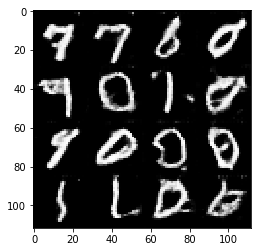

Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 1.8598... Generator Loss: 0.2150
Epoch 2/2... Discriminator Loss: 1.6610... Generator Loss: 0.2997
Epoch 2/2... Discriminator Loss: 1.6571... Generator Loss: 0.3275
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 1.8252... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 0.6947


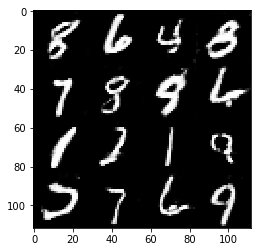

Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.6260... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 1.6662... Generator Loss: 0.3422
Epoch 2/2... Discriminator Loss: 1.8508... Generator Loss: 0.2620
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 1.7397... Generator Loss: 0.2761
Epoch 2/2... Discriminator Loss: 1.6450... Generator Loss: 0.3210
Epoch 2/2... Discriminator Loss: 1.8979... Generator Loss: 0.2423
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 1.0668


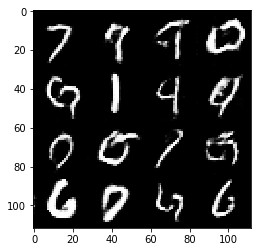

Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 1.0172
Epoch 2/2... Discriminator Loss: 1.7147... Generator Loss: 1.6518
Epoch 2/2... Discriminator Loss: 1.7913... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.6190
Epoch 2/2... Discriminator Loss: 1.5518... Generator Loss: 0.5146
Epoch 2/2... Discriminator Loss: 1.7863... Generator Loss: 0.2734
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 2.1569... Generator Loss: 0.1903
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.8068... Generator Loss: 0.2959


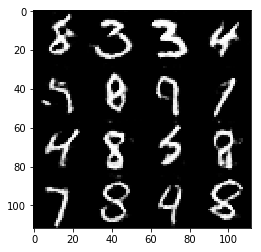

Epoch 2/2... Discriminator Loss: 1.9585... Generator Loss: 0.2354
Epoch 2/2... Discriminator Loss: 1.5834... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 1.8434... Generator Loss: 0.2646
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 1.9396... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.8276... Generator Loss: 0.3003
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.7950... Generator Loss: 0.2715
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.5397


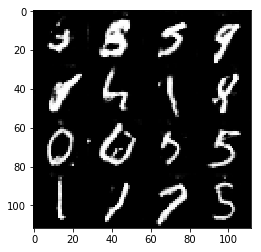

Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 1.0603
Epoch 2/2... Discriminator Loss: 1.6860... Generator Loss: 0.2775
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 1.5692... Generator Loss: 1.4582
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.3950
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.6490... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 1.7532... Generator Loss: 0.3202


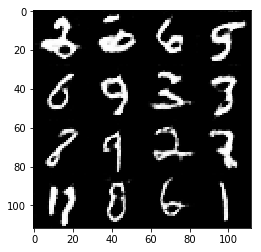

Epoch 2/2... Discriminator Loss: 2.2123... Generator Loss: 0.1643
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 2.0802... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 1.5709... Generator Loss: 1.9886
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 2.0144... Generator Loss: 0.1997
Epoch 2/2... Discriminator Loss: 1.7677... Generator Loss: 0.2525
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.5816
Epoch 2/2... Discriminator Loss: 1.7175... Generator Loss: 0.3095


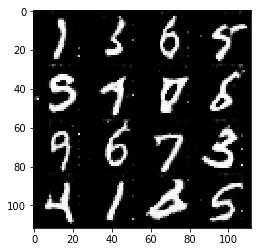

Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 2.3531... Generator Loss: 0.1542
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 1.0166
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 2.4479... Generator Loss: 0.1408
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.3689
Epoch 2/2... Discriminator Loss: 2.0723... Generator Loss: 1.2961


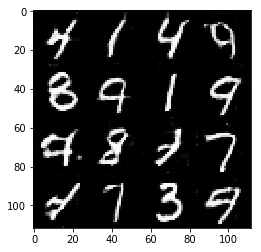

Epoch 2/2... Discriminator Loss: 1.4902... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.9869
Epoch 2/2... Discriminator Loss: 1.7130... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 1.1547


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1731... Generator Loss: 0.3305
Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 6.2918
Epoch 1/1... Discriminator Loss: 0.1986... Generator Loss: 8.0198
Epoch 1/1... Discriminator Loss: 2.0355... Generator Loss: 5.2257
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 6.3823
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 2.9391


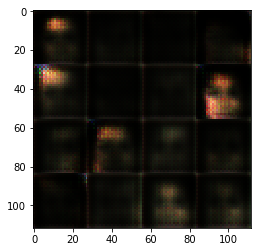

Epoch 1/1... Discriminator Loss: 1.9879... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 2.0015... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.8267... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 2.3654... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.7138... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6161


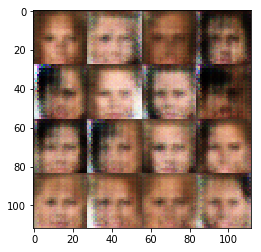

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.8063... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 1.3872


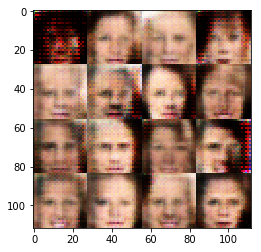

Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.7540... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.9560... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.7135... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6076


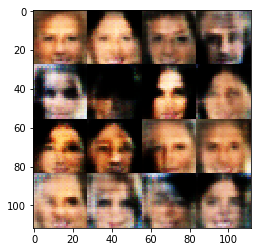

Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.9357... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6853


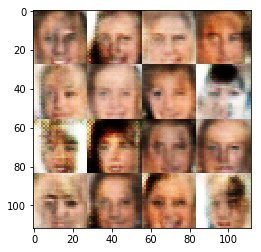

Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.8274... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.8587... Generator Loss: 1.0817


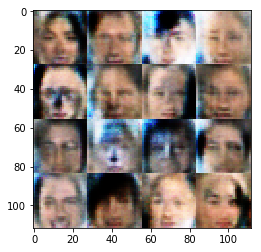

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.6814... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.7875... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 1.1687


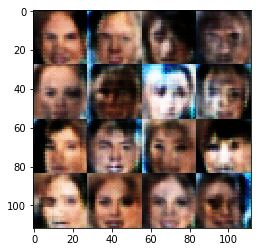

Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 2.6093... Generator Loss: 2.2173
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.9632


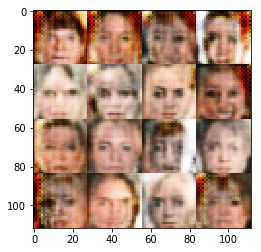

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6205


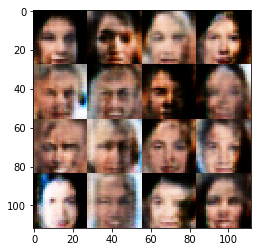

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 2.0546... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 0.8809


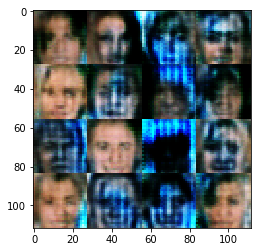

Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: 1.7279... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.8262... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.5174


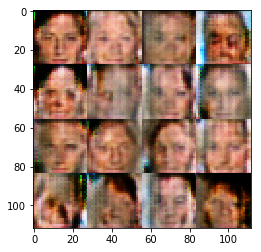

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 2.0253... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.8039... Generator Loss: 0.2712
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8261


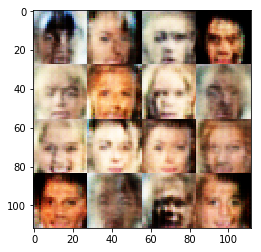

Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 2.5757... Generator Loss: 0.0930
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7846


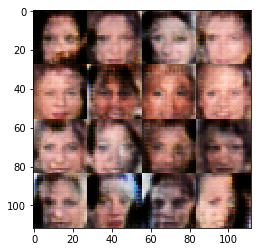

Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.7104... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.9308


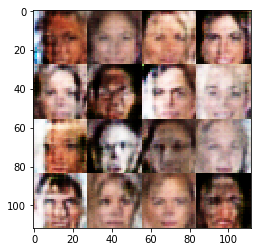

Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.8156... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 2.6355... Generator Loss: 0.1171
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.5999


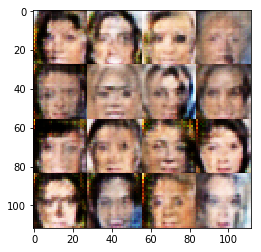

Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8061


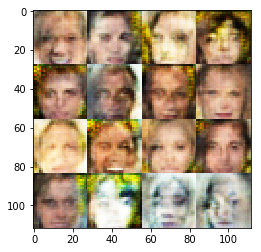

Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8567


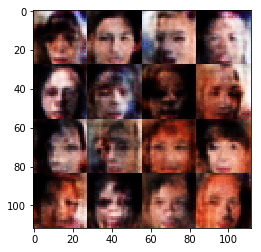

Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.6772


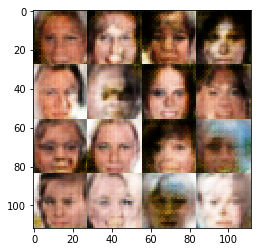

Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7083


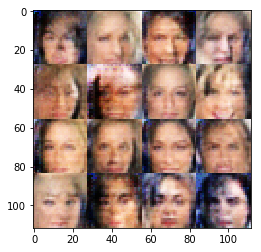

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6290


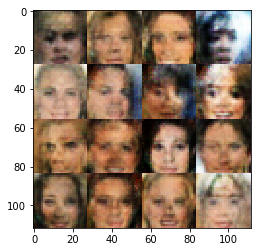

Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7133


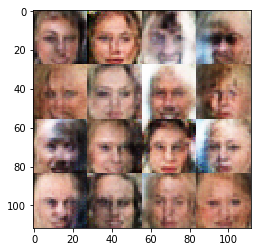

Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5149


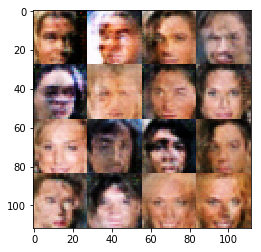

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6481


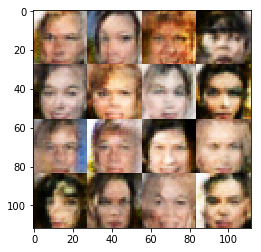

Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6154


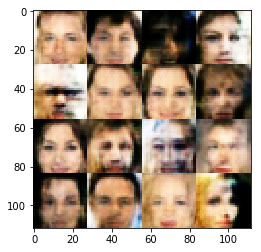

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.5422


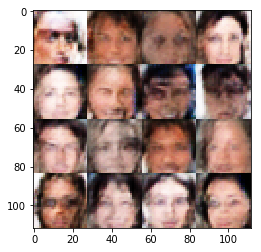

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.7264... Generator Loss: 0.3073
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7468


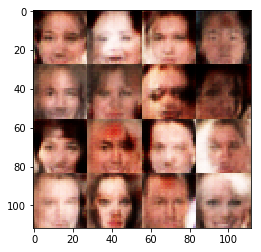

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 2.1878... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 2.3719... Generator Loss: 0.2429
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7331


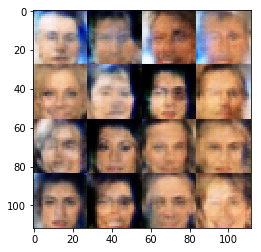

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4349


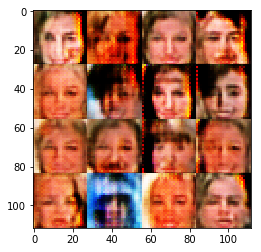

Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.5641


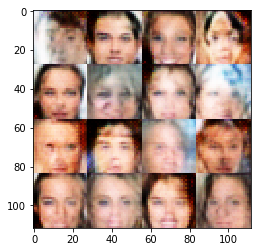

Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6808


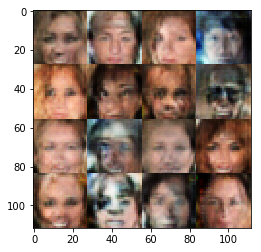

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 2.2296... Generator Loss: 0.1987
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.3569


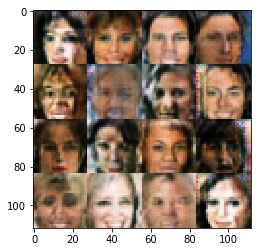

Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7084


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.